# Classification of real data

## Install required python modules

In [ ]:
%%bash
pip install -e ../.

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [1]:
import numpy as np
from openpyxl import load_workbook
import pandas as pd


filename_data = '../data/Real_data/ST001706/1D/RCCdata.txt'
filename_status = '../data/Real_data/ST001706/RCC_samples.xlsx'
df_data = pd.DataFrame(np.loadtxt(filename_data, dtype=float))
df_status = pd.read_excel(filename_status, engine='openpyxl', header=None)

#Convert status into integers
df_status[0] = df_status[0].astype('category')
df_status = df_status.apply(lambda x: x.cat.codes)

In [3]:
print(df_data.shape)
print(df_status.shape)

(256, 32697)
(256, 1)


## Shuffle the data

In [4]:
from sklearn.utils import shuffle

df_status, df_data = shuffle(df_status, df_data)

## Convert into tf.data

In [5]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_data, df_status[0].tolist()))
dataset.element_spec

(TensorSpec(shape=(32697,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [6]:
from tfrecords import write_tfrecords

In [7]:
write_tfrecords('../data/tfrecords/Real_data', dataset=dataset, number=10)

## Read the tf.Record files

In [8]:
from tfrecords import read_tfrecords

In [9]:
file_paths = ['../data/tfrecords/Real_data/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords(file_paths)

## Split data into train and validation datasets

In [10]:
from models import process_dataset

In [11]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[8] * 3, shuffle_buffers=1000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [47]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/real_data")

## Define MLPs

In [99]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(32697,), hidden_units=[64, 64])
simple_model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                2092672   
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 65        
Total params: 2,096,897
Trainable params: 2,096,897
Non-trainable params: 0
_________________________________________________________________


In [100]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(32697,), hidden_units=[1024, 1024, 1024, 512, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_67 (Dense)             (None, 1024)              33482752  
_________________________________________________________________
batch_normalization_36 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_37 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)            

## Compile model

In [102]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=100)

In [103]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt, earlystopping])

Epoch 1/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.8308 - binary_accuracy: 0.6750 - val_loss: 0.4868 - val_binary_accuracy: 0.8200
Epoch 2/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.3958 - binary_accuracy: 0.8450 - val_loss: 0.2551 - val_binary_accuracy: 0.9000
Epoch 3/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.3098 - binary_accuracy: 0.8500 - val_loss: 0.3567 - val_binary_accuracy: 0.8200
Epoch 4/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.2423 - binary_accuracy: 0.9200 - val_loss: 0.2141 - val_binary_accuracy: 0.9200
Epoch 5/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1876 - binary_accuracy: 0.9400 - val_loss: 0.2141 - val_binary_accuracy: 0.9200
Epoch 6/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1620 - binary_accuracy: 0.9450 - val_loss: 0.2032 - val_binary_accuracy: 0.8800
Epoch 7/1000
25/25 [==============================] - 0s 9ms

25/25 [==============================] - 0s 8ms/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 0.5182 - val_binary_accuracy: 0.9000
Epoch 54/1000
25/25 [==============================] - 0s 9ms/step - loss: 9.2263e-04 - binary_accuracy: 1.0000 - val_loss: 0.4841 - val_binary_accuracy: 0.9200
Epoch 55/1000
25/25 [==============================] - 0s 9ms/step - loss: 9.1747e-04 - binary_accuracy: 1.0000 - val_loss: 0.5073 - val_binary_accuracy: 0.9000
Epoch 56/1000
25/25 [==============================] - 0s 8ms/step - loss: 8.5173e-04 - binary_accuracy: 1.0000 - val_loss: 0.5155 - val_binary_accuracy: 0.9000
Epoch 57/1000
25/25 [==============================] - 0s 9ms/step - loss: 8.4121e-04 - binary_accuracy: 1.0000 - val_loss: 0.5229 - val_binary_accuracy: 0.9000
Epoch 58/1000
25/25 [==============================] - 0s 8ms/step - loss: 7.8844e-04 - binary_accuracy: 1.0000 - val_loss: 0.4981 - val_binary_accuracy: 0.9200
Epoch 59/1000
25/25 [==============================]

Epoch 104/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.9017e-04 - binary_accuracy: 1.0000 - val_loss: 0.6091 - val_binary_accuracy: 0.9000
Epoch 105/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.8791e-04 - binary_accuracy: 1.0000 - val_loss: 0.6062 - val_binary_accuracy: 0.9000
Epoch 106/1000
25/25 [==============================] - 0s 8ms/step - loss: 1.8016e-04 - binary_accuracy: 1.0000 - val_loss: 0.6107 - val_binary_accuracy: 0.9000
Epoch 107/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.7754e-04 - binary_accuracy: 1.0000 - val_loss: 0.6128 - val_binary_accuracy: 0.9000
Epoch 108/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.7301e-04 - binary_accuracy: 1.0000 - val_loss: 0.6236 - val_binary_accuracy: 0.9000
Epoch 109/1000
25/25 [==============================] - 0s 9ms/step - loss: 1.6948e-04 - binary_accuracy: 1.0000 - val_loss: 0.6215 - val_binary_accuracy: 0.9000
Epoch 110/1000
25/25 [======

## Plot the learning curves

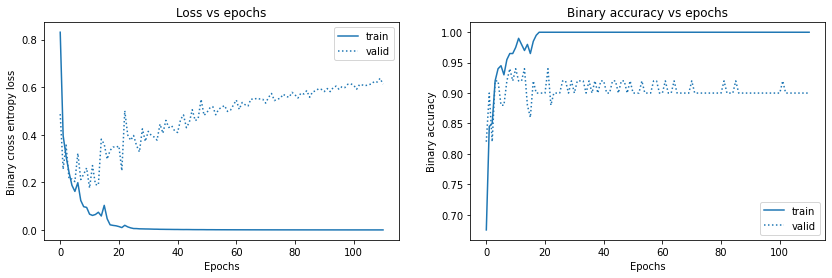

In [104]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Load saved model

In [107]:
from models import get_simple_mlp
import tensorflow as tf


simple_model_load = get_simple_mlp(input_shape=(32697,), hidden_units=[64, 64])
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
simple_model_load.compile(optimizer=opt, loss=loss, metrics=[acc])
status = tf.train.Checkpoint(model=simple_model_load).restore(tf.train.latest_checkpoint('../saved_models/real_data')).expect_partial()
status.assert_existing_objects_matched()
simple_model_load.evaluate(val_dataset, return_dict=True, verbose=0)


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                2092672   
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 2,096,897
Trainable params: 2,096,897
Non-trainable params: 0
_________________________________________________________________


{'loss': 0.17636698484420776, 'binary_accuracy': 0.9399999976158142}

## Plot examples with predictions

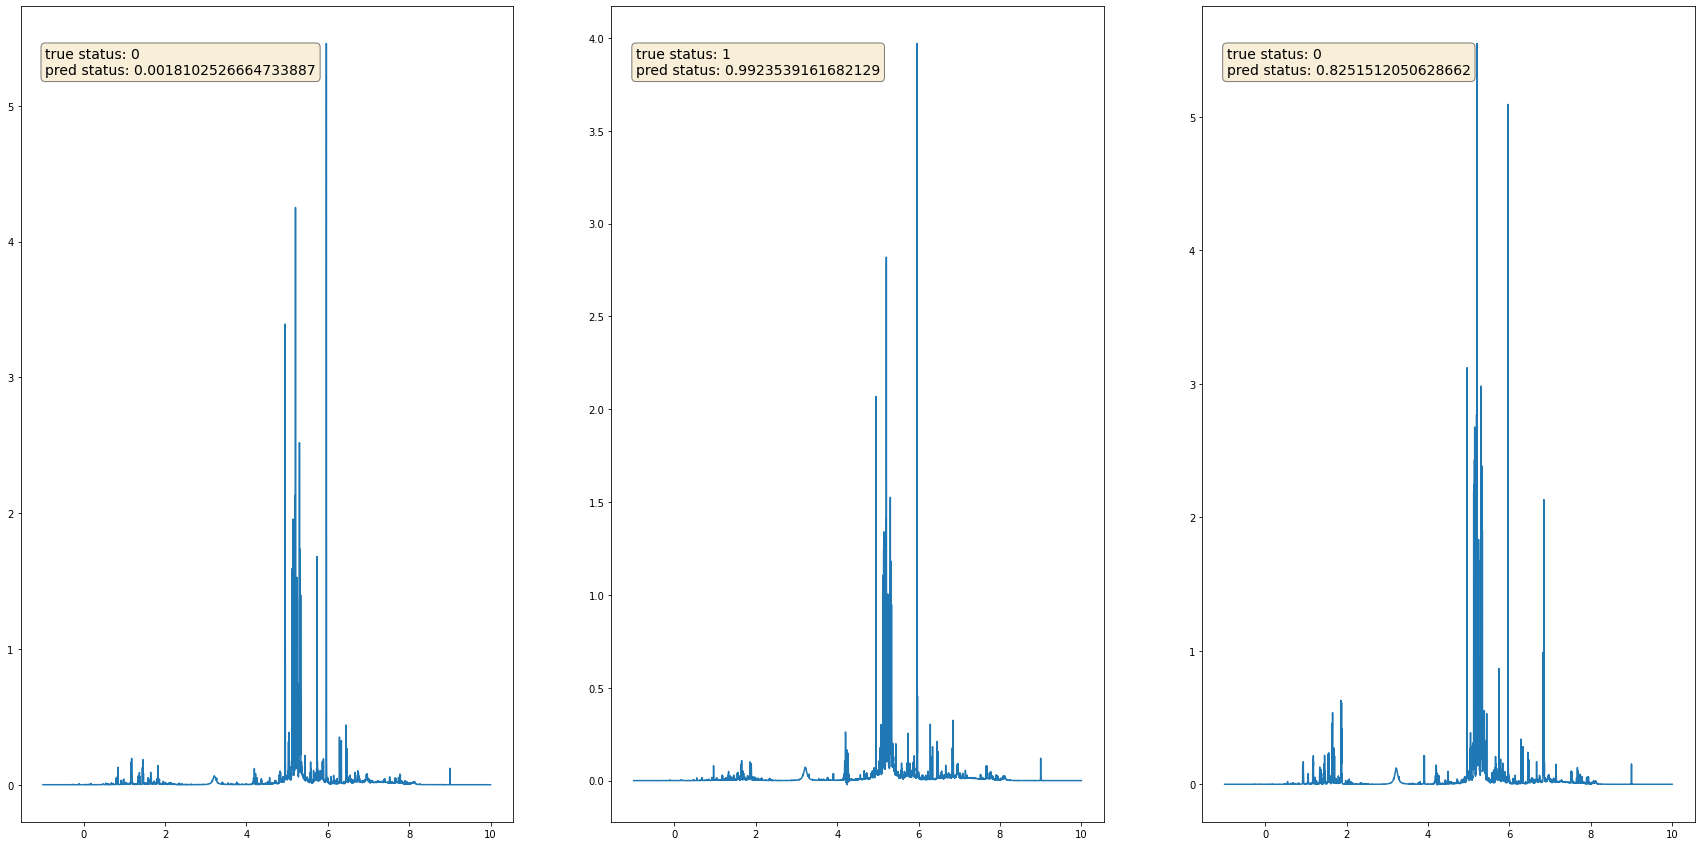

In [127]:
#Plot samples
import matplotlib.pyplot as plt
import numpy as np

for parsed_record in val_dataset.shuffle(10).take(1):
    data_points_0 = parsed_record[0][0]
    data_points_1 = parsed_record[0][1]
    data_points_2 = parsed_record[0][2]
    true_status_0 = parsed_record[1][0].numpy()
    true_status_1 = parsed_record[1][1].numpy()
    true_status_2 = parsed_record[1][2].numpy()
    pred_status_0 = simple_model.predict(parsed_record[0])[0][0]
    pred_status_1 = simple_model.predict(parsed_record[0])[1][0]
    pred_status_2 = simple_model.predict(parsed_record[0])[2][0]


import matplotlib.pyplot as plt

label_0 = '\n'.join((
    r'true status: {}'.format(true_status_0),
    r'pred status: {}'.format(pred_status_0)))

label_1 = '\n'.join((
    r'true status: {}'.format(true_status_1),
    r'pred status: {}'.format(pred_status_1)))

label_2 = '\n'.join((
    r'true status: {}'.format(true_status_2),
    r'pred status: {}'.format(pred_status_2)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 15))
x_axis_0 = np.linspace(-1, 10, num=data_points_0.shape[0])
x_axis_1 = np.linspace(-1, 10, num=data_points_1.shape[0])
x_axis_2 = np.linspace(-1, 10, num=data_points_2.shape[0])
axes[0].plot(x_axis_0, data_points_0, label=[('true status: ', true_status_0), ('pred status: ', pred_status_0)])
axes[1].plot(x_axis_1, data_points_1)
axes[2].plot(x_axis_2, data_points_2)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, label_0, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[1].text(0.05, 0.95, label_1, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[2].text(0.05, 0.95, label_2, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

## Try random forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_data, df_status[0], test_size=0.2, random_state=42)

clf = RandomForestClassifier(1000, random_state=0, oob_score=True, max_features=700)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=700, n_estimators=1000, oob_score=True,
                       random_state=0)

In [97]:
print("Train accuracy :", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))

Train accuracy : 1.0
Test accuracy : 0.9230769230769231
